# WNTR Salt Water Intrusion Tutorial
The following tutorial illustrates the use of storm surge data associated with hurricanes to model salt water intrusion into a water distribution system.  

The analysis uses storm surge data from [EPA's Creating Resilient Water Utilities (CRWU) website](https://epa.maps.arcgis.com/apps/MapSeries/index.html?appid=852ca645500d419e8c6761b923380663), which sources data from [National Oceanic and Atmospheric Administration's (NOAA's) Sea, Lake, and Overland Surge from Hurricanes (SLOSH) model](https://www.nhc.noaa.gov/nationalsurge/).  The SLOSH model is used by the National Weather Service to estimate storm surge during hurricanes. To simplify the analysis, the salt water inundation rate into the water distribution system is assumed to be proportional to storm surge depth.  More detailed analysis could be pursued by following the methodology laid out by Moglen et. al. in their paper titled ["A nexus approach to infrastructure resilience planning under uncertainty"](https://www.sciencedirect.com/science/article/pii/S0951832022005464).

The water network model used in the analysis is ky4 from the [UKnowledge Water Distribution Systems Research Database](https://uknowledge.uky.edu/wdsrd/). The model coordinates were moved to a coastal location near Tampa for the tutorial.

# Imports
Import WNTR and other Python packages needed for the tutorial.
- os.path.join is required to define file paths
- Numpy is required to create and manipulate arrays
- Rasterio is used to load and plot the storm surge data 
- Matplotlib is required to create graphics

In [24]:
from os.path import join
import numpy as np
import rasterio as rs
from rasterio.plot import show
import matplotlib.pyplot as plt
import wntr

# Create the WaterNetworkModel

Load the EPANET INP file into WNTR to create a WaterNetworkModel

In [25]:
network_path = "../data/coastal_ky4.inp"
wn = wntr.network.WaterNetworkModel(network_path) 

Set simulation time and water quality options

In [26]:
# set time options to run at hourly time steps for eight days
wn.options.time.hydraulic_timestep = 3600
wn.options.time.quality_timestep = 3600
wn.options.time.duration = 3600 * 192

# Set parameter type for quality simulation and add a name for the chemical
wn.options.quality.parameter = "CHEMICAL"
wn.options.quality.chemical_name = "NaCl"

GeoDataFrames are created from the WaterNetworkModel using `to_gis`.  The GeoDataFrames are used in associate junctions with the storm surge data.

In [27]:
wn_gis = wn.to_gis(crs="EPSG:4269")

Plot the water network model

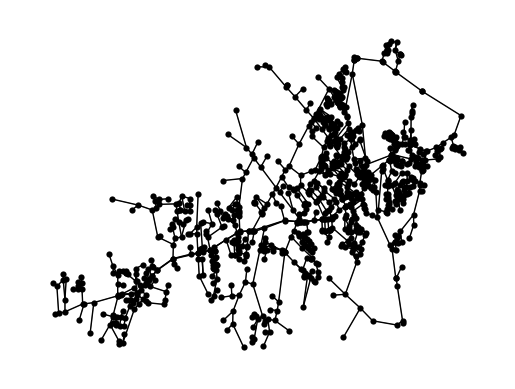

In [28]:
fig, ax = plt.subplots()
ax = wntr.graphics.plot_network(wn, ax=ax) #, show_plot=False) TODO why is this needed

# Load storm surge data
For the purposes of this tutorial, a subset of the storm surge raster data is used to keep file size small. To download the entire raster dataset, navigate to the [NOAA National Storm Surge Risk Maps webpage](https://www.nhc.noaa.gov/nationalsurge/). Scroll down to the "Data Availability and Download" section and use the link labeled "Texas to Maine (high tide scenario)" to obtain a zip file containing the storm surge scenarios. Unzip the folder and adjust the `raster_path` variable below to point to the folder's location. 

Load the raster data using the geographic extent of the water network model.

In [29]:
raster_path = join("..", "data", "coastal_ky4_storm_surge.tif")

min_lon, min_lat, max_lon, max_lat = wn_gis.junctions.total_bounds

with rs.open(raster_path) as src:
    window = rs.windows.from_bounds(min_lon, min_lat, max_lon, max_lat, src.transform)
    inundation_raster = src.read(1, window=window)
    raster_transform = src.window_transform(window)
    raster_crs = src.crs

Convert raster data to float and convert missing data values (255) to NaN

In [30]:
inundation_raster = inundation_raster.astype(float) # change dtype from int to float to allow for NaN value
inundation_raster[inundation_raster==255] = np.nan # 255 indicates no data

Plot the storm surge data

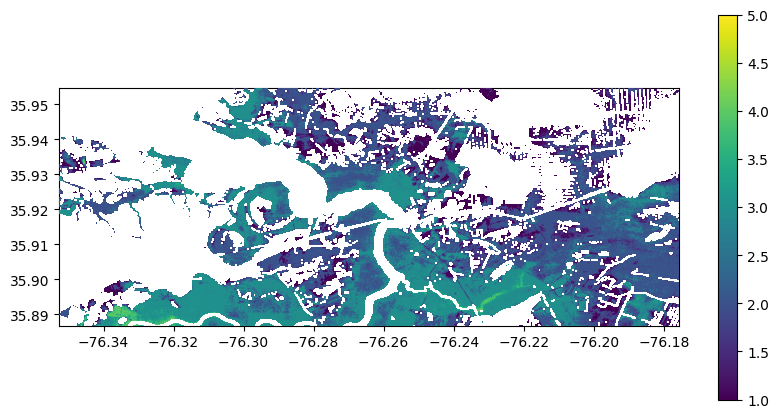

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
imshow = show(inundation_raster, transform=raster_transform, ax=ax, zorder=5)
im = imshow.get_images()[0]
fig.colorbar(im, ax=ax, shrink=0.5)

# Associate storm surge data with the WaterNetworkModel

WNTR's `sample_raster` function provides a way to associate raster values to point geometries, such as junctions.

In [32]:
junctions = wn_gis.junctions
junctions['inundation_level'] = wntr.gis.sample_raster(junctions, raster_path, bands=1)
print(junctions['inundation_level'].head())

name
J-1      2.0
J-10     NaN
J-100    NaN
J-101    2.0
J-102    NaN
Name: inundation_level, dtype: float64


Plot junctions with storm surge level

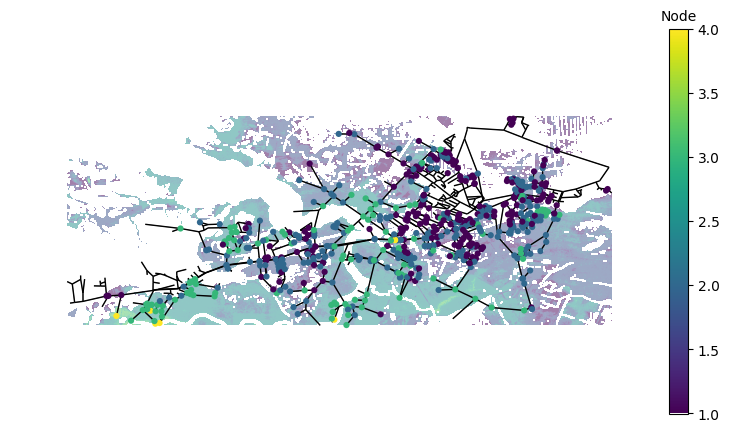

In [33]:
fig, ax = plt.subplots(figsize=(10,10))

# plot storm surge data
im = show(inundation_raster, transform=raster_transform, 
          vmin=np.nanmin(inundation_raster), vmax=np.nanmax(inundation_raster), 
          ax=ax, alpha=0.5)

# plot junctions with associated inundation level
ax = wntr.graphics.plot_network(wn, node_attribute=junctions["inundation_level"], node_cmap="viridis", ax=ax)

# Add salt water intrusion to the WaterNetworkModel
The analysis uses storm surge values to determine salt water intrusion across the WaterNetworkModel. Salt water intrusion is modeled using concentration sources (CONCEN) to inject salt water into the system at junctions inundated by the storm. The inundation rate is assumed to be proportional to the storm surge depth. The concentration of salt is set to 35 kg / m^3.  The analysis assumes that the storm surge starts at hour 2 and ends at hour 22.


To model saltwater intrusion at each junction, the level of sea water inundation is used to determine the amount of salt water entering the system at each junction. The density of salt in sea water is 35 kg/m^3. In this analysis, the inundation bins levels from 0-6 are linearly converted to salt water densities with 0 having no salt water and 6 having the maximum density of salt water.

Estimate salt water intrusion rate using inundation levels

In [34]:
salt_water_flowrate = junctions["inundation_level"].copy()
salt_water_flowrate[:] = - 0.0001 * salt_water_flowrate[:] # m3/s
print(salt_water_flowrate.head())

name
J-1     -0.0002
J-10        NaN
J-100       NaN
J-101   -0.0002
J-102       NaN
Name: inundation_level, dtype: float64


Plot salt water flowrate distribution

Text(0.5, 1.0, 'Distribution of salt water flowrate')

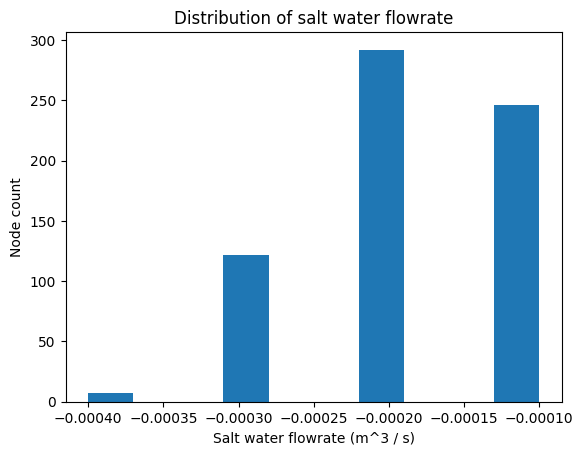

In [35]:
fig, ax = plt.subplots()
ax.hist(salt_water_flowrate)
ax.set_xlabel("Salt water flowrate (m^3 / s)")
ax.set_ylabel("Node count")
ax.set_title("Distribution of salt water flowrate")

Add a binary pattern to the WaterNetworkModel to create the concentration source.  The binary pattern starts at hour 2 and ends at hour 22.

In [36]:
storm_start = 2*3600
storm_end = 22*3600
source_pattern = wntr.network.elements.Pattern.binary_pattern('StormSurge',
    start_time=storm_start, end_time=storm_end, duration=wn.options.time.duration,
    step_size=wn.options.time.pattern_timestep)

wn.add_pattern('StormSurge', source_pattern)

Add a source at each junction that is inundated, using the estimated flow rates and salt water density

In [37]:
inundated = salt_water_flowrate < 0.0
salt_water_density = 35 # kg/m3 
for junction_name in wn.junction_name_list:
    if inundated[junction_name]:
        junction = wn.get_node(junction_name)
        wn.add_source(f'Source_{junction_name}', junction_name, 'CONCEN', salt_water_density, 'StormSurge')
        junction.add_demand(base=salt_water_flowrate[junction_name], pattern_name='StormSurge')

# Run the baseline storm surge simulation

Simulate hydraulics and water quality, extract water quality results

In [38]:
sim = wntr.sim.EpanetSimulator(wn)
baseline_results = sim.run_sim()
baseline_quality = baseline_results.node['quality']
print(baseline_quality.head())

name        J-1  J-10     J-100      J-101  J-102  J-103  J-104  J-105  \
0      0.000000   0.0  0.000000   0.000000    0.0    0.0    0.0    0.0   
3600   0.000000   0.0  0.000000   0.000000    0.0    0.0    0.0    0.0   
7200   0.000000   0.0  0.000000   0.000000    0.0    0.0    0.0    0.0   
10800  1.386737   0.0  0.001646   6.234949    0.0    0.0    0.0   35.0   
14400  3.360756   0.0  0.023401  12.340333    0.0    0.0    0.0   35.0   

name      J-106      J-107  ...      J-99  I-Pump-1  O-Pump-2  O-Pump-1  \
0      0.000000   0.000000  ...   0.00000       0.0       0.0       0.0   
3600   0.000000   0.000000  ...   0.00000       0.0       0.0       0.0   
7200   0.000000   0.000000  ...   0.00000       0.0       0.0       0.0   
10800  2.495438  17.458763  ...   4.48945       0.0       0.0       0.0   
14400  6.519385  17.458763  ...  12.33990       0.0       0.0       0.0   

name   I-Pump-2  R-1       T-1       T-2       T-3       T-4  
0           0.0  0.0  0.000000  0.000000 

Plot results

Text(0, 0.5, 'Salt water density (kg/m^3)')

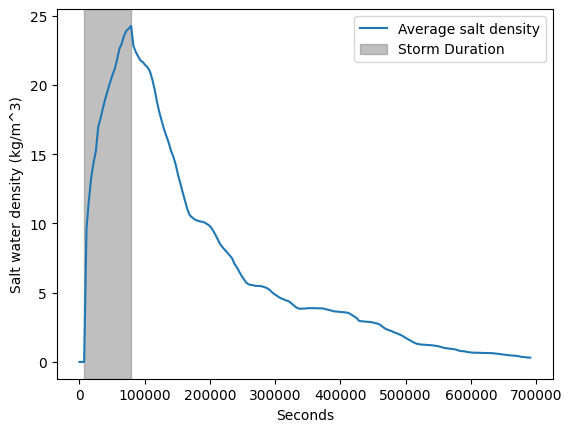

In [39]:
fig, ax = plt.subplots()
baseline_quality.mean(axis=1).plot(ax=ax, label="Average salt density")
ax.axvspan(storm_start, storm_end, color='grey', alpha=0.5, label="Storm Duration")
ax.legend()
ax.set_xlabel("Seconds")
ax.set_ylabel("Salt water density (kg/m^3)")

Plot average salt water concentration during the storm surge

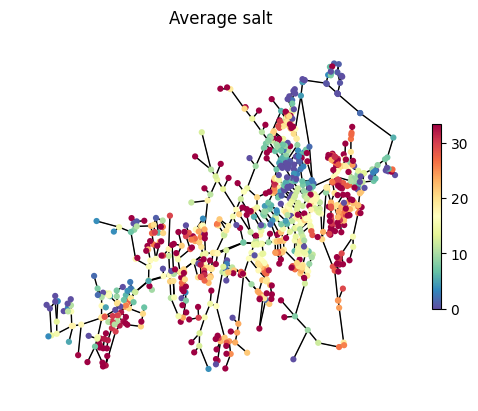

In [40]:
avg_salt_water = baseline_quality.loc[storm_start:storm_end].mean(axis=0)
ax = wntr.graphics.plot_network(wn, node_attribute=avg_salt_water, node_colorbar_label="", title="Average salt")

# Run a storm surge simulation with flushing response
Hydrant flushing locations are selected to remove salt water from the system.  The locations are randomly selected, however other selection methods could also be used.

In [41]:
np.random.seed(1234)
number_of_hydrants = 5

hydrant_nodes = list(np.random.choice(wn.junction_name_list, number_of_hydrants))

Plot hydrant locations

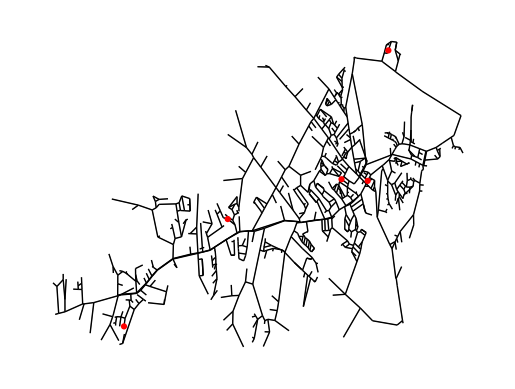

<Axes: >

In [42]:
wntr.graphics.plot_network(wn, node_attribute=hydrant_nodes)

Add fire flow demand at the hydrant locations to flush the system

In [43]:
fire_flow_demand = 0.126 # 2000 gal/min
hydrant_start = storm_end
hydrant_end = storm_end + 72 * 3600

for hydrant_node in hydrant_nodes:
    junction = wn.get_node(hydrant_node)
    junction.add_fire_fighting_demand(wn, fire_flow_demand, hydrant_start, hydrant_end)

Run the simulation with flushing response and extract water quality results

In [44]:
sim = wntr.sim.EpanetSimulator(wn)
response_results = sim.run_sim()
response_quality = response_results.node['quality']
print(response_quality.head())

name        J-1  J-10     J-100      J-101  J-102  J-103  J-104  J-105  \
0      0.000000   0.0  0.000000   0.000000    0.0    0.0    0.0    0.0   
3600   0.000000   0.0  0.000000   0.000000    0.0    0.0    0.0    0.0   
7200   0.000000   0.0  0.000000   0.000000    0.0    0.0    0.0    0.0   
10800  1.386737   0.0  0.001646   6.234949    0.0    0.0    0.0   35.0   
14400  3.360756   0.0  0.023401  12.340333    0.0    0.0    0.0   35.0   

name      J-106      J-107  ...      J-99  I-Pump-1  O-Pump-2  O-Pump-1  \
0      0.000000   0.000000  ...   0.00000       0.0       0.0       0.0   
3600   0.000000   0.000000  ...   0.00000       0.0       0.0       0.0   
7200   0.000000   0.000000  ...   0.00000       0.0       0.0       0.0   
10800  2.495438  17.458763  ...   4.48945       0.0       0.0       0.0   
14400  6.519385  17.458763  ...  12.33990       0.0       0.0       0.0   

name   I-Pump-2  R-1       T-1       T-2       T-3       T-4  
0           0.0  0.0  0.000000  0.000000 

Plot results

Text(0, 0.5, 'Salt water density (kg/m^3)')

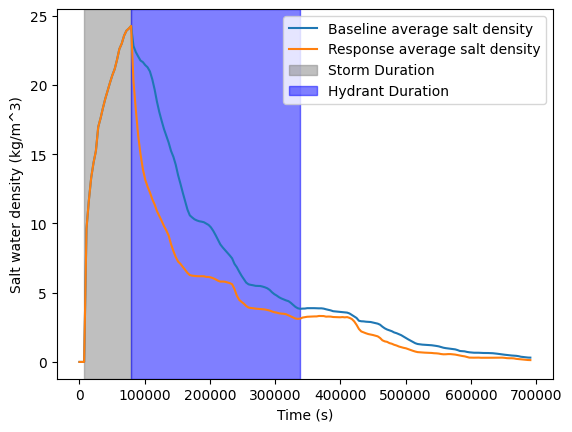

In [45]:
fig, ax = plt.subplots()
baseline_quality.mean(axis=1).plot(ax=ax, label="Baseline average salt density")
response_quality.mean(axis=1).plot(ax=ax, label="Response average salt density")
ax.axvspan(storm_start, storm_end, color='grey', alpha=0.5, label="Storm Duration")
ax.axvspan(hydrant_start, hydrant_end, color='blue', alpha=0.5, label="Hydrant Duration")
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Salt water density (kg/m^3)")